<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_3_network_in_network_nin_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):

  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten())

In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [5]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 2

In [6]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [7]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [9]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):

  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  num_batches = len(train_iter)

  train_x = []
  test_x = []
  train_loss = []
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      train_l = metric[0] / metric[2]
      train_a = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        train_loss.append(train_l)
        train_acc.append(train_a)
        train_x.append(epoch + (i + 1) / num_batches)
    test_acc.append(evaluate_accuracy_gpu(net, test_iter))
    test_x.append(epoch + 1)
    print(f'epoch: {(epoch + 1):f}, train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')

  print(f'train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')
  plt.plot(train_x, train_loss, 'r')
  plt.plot(train_x, train_acc, 'b')
  plt.plot(test_x, test_acc, 'g')
  plt.show()

In [10]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [11]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
    
  def __getitem__(self, idx):
    return self.data[idx]

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

training on cuda:0
epoch: 1.000000, train loss 2.294, train acc 0.141, test acc 0.200
epoch: 2.000000, train loss 1.882, train acc 0.363, test acc 0.491
epoch: 3.000000, train loss 1.342, train acc 0.525, test acc 0.540
epoch: 4.000000, train loss 1.051, train acc 0.599, test acc 0.556
epoch: 5.000000, train loss 0.952, train acc 0.636, test acc 0.631
epoch: 6.000000, train loss 0.902, train acc 0.651, test acc 0.662
epoch: 7.000000, train loss 0.867, train acc 0.663, test acc 0.671
epoch: 8.000000, train loss 0.841, train acc 0.670, test acc 0.677
epoch: 9.000000, train loss 0.819, train acc 0.678, test acc 0.663
epoch: 10.000000, train loss 0.804, train acc 0.684, test acc 0.624
train loss 0.804, train acc 0.684, test acc 0.624


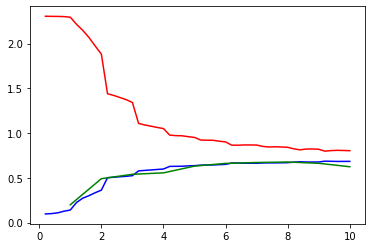

In [13]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())